In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'DejaVu Sans', 'serif': ['Computer Modern'], 'size':15})
rc('figure', facecolor='w')
import astropy.io.fits as fits
from astropy.io import ascii
import math, os

#optional dependencies
from distutils.spawn import find_executable
if find_executable('latex'): rc('text', usetex=True)
else: rc('text', usetex=False)
    
from bsub import bsub

In [183]:
def findStar(red, **kwargs):
    percentile = kwargs.get('percentile', 99)
    cut = np.percentile(red.flatten(), percentile)
    pts = []
    for row in range(red.shape[0]):
        idx = np.where(red[row] >= cut)[0]
        if (len(idx) != 0) & (row != 255):
            for col in idx:
                pts.append([row, col])
    pts = np.array(pts)
    return pts

def plotImg(arr, **kwargs):
    
    percentile = kwargs.get('percentile', 99)
    avg = np.mean(arr.flatten())
    std = np.std(arr.flatten())
    dim = arr.shape
    
    fig, ax = plt.subplots(1)
    pl = plt.imshow(arr, origin='lower', interpolation='nearest', cmap='gray_r', \
                    vmin=np.percentile(arr, .5), vmax=np.percentile(arr, 95.5))
    star_pts = findStar(arr, percentile=percentile)
    xpts, ypts = [], []
    for pts in star_pts:
        if (pts[1] != 255) & (pts[1] != 256) & (pts[1] < 1000):
            xpts.append(pts[0])
            ypts.append(pts[1])
    plt.scatter(ypts, xpts, marker='1', s=50, color='r')

    plt.colorbar(pl).set_label('Detector Value (ADU)')
    plt.xlabel('pixels(x)')
    plt.ylabel('pixels(y)')
    plt.xlim(0, dim[0])
    plt.ylim(0, dim[1])
    if 'save' in kwargs:
        plt.savefig(kwargs.get('save'))
    plt.show()

In [45]:
fnum = '159'
flat = fits.getdata('data/demo/d121.fits')
dat = fits.getdata('data/demo/d%s.fits'%(fnum))
hdr = fits.getheader('data/demo/d%s.fits'%(fnum))

datab = bsub(dat, hdr.get('cover')) 
flatb = bsub(flat, hdr.get('cover')) 
flatb = flatb/np.median(flatb)
red = datab/flatb

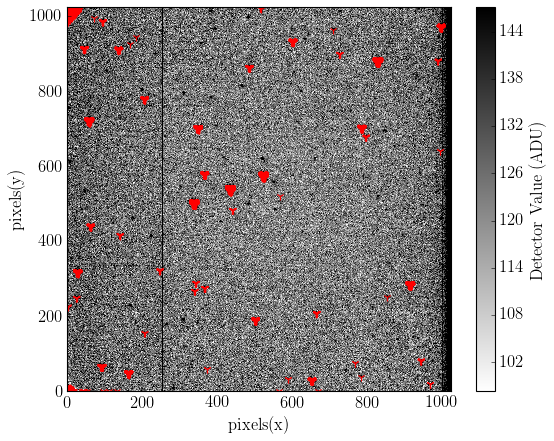

In [187]:
plotImg(red, rng=[0,500], percentile=99.4)

In [171]:
pts = findStar(red, percentile=99)